In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
import numpy as np

import CellTracker.trackerlite as trl
import CellTracker.stardistwrapper as sdw
import CellTracker.coord_image_transformer as cit
from CellTracker.analyses import draw_signals



In [2]:
stardist_model_name = "20231101-185322tdTomato"

model = sdw.load_stardist_model(model_name=stardist_model_name)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.254113, nms_thresh=0.3.
Load pretrained stardist model '20231101-185322tdTomato' from folder 'stardist_models'


# 一括でフォルダ内にあるhdf5にトラッキングを行い、そのフォルダ内にトラッキング結果を格納していきます。

# 初めにそれらのpathと、トラッキングを行うボリュームを選択してください。




20231101-175925tdTomato_0umpersec-2000umdz_raw_gzip.h5 is under processing



Raw image shape at vol1: (20, 300, 498)
1/1 [==============================] - 0s 26ms/step


Segmenting images:   0%|    | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Segmenting images:  20%|▏| 1/5 [00:00<00:02,  1.97

1/1 [==============================] - 0s 20ms/step


Segmenting images:  40%|▍| 2/5 [00:00<00:01,  2.01

1/1 [==============================] - 0s 21ms/step


Segmenting images:  60%|▌| 3/5 [00:01<00:00,  2.06

1/1 [==============================] - 0s 20ms/step


Segmenting images:  80%|▊| 4/5 [00:01<00:00,  2.06

1/1 [==============================] - 0s 20ms/step


Segmenting images: 100%|█| 5/5 [00:02<00:00,  2.06


All images from t=1 to t=5 have been Segmented
Loaded the proofed segmentations at vol 1 with 164 cells
Interpolating images along z-axis...
The interpolated segmentations at vol 1 contains 166 cells
Calculating coordinates of cell centers...
3/3 [==============================] - 0s 2ms/step


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (300, 498, 20) and arg 1 with shape (300, 498, 97).

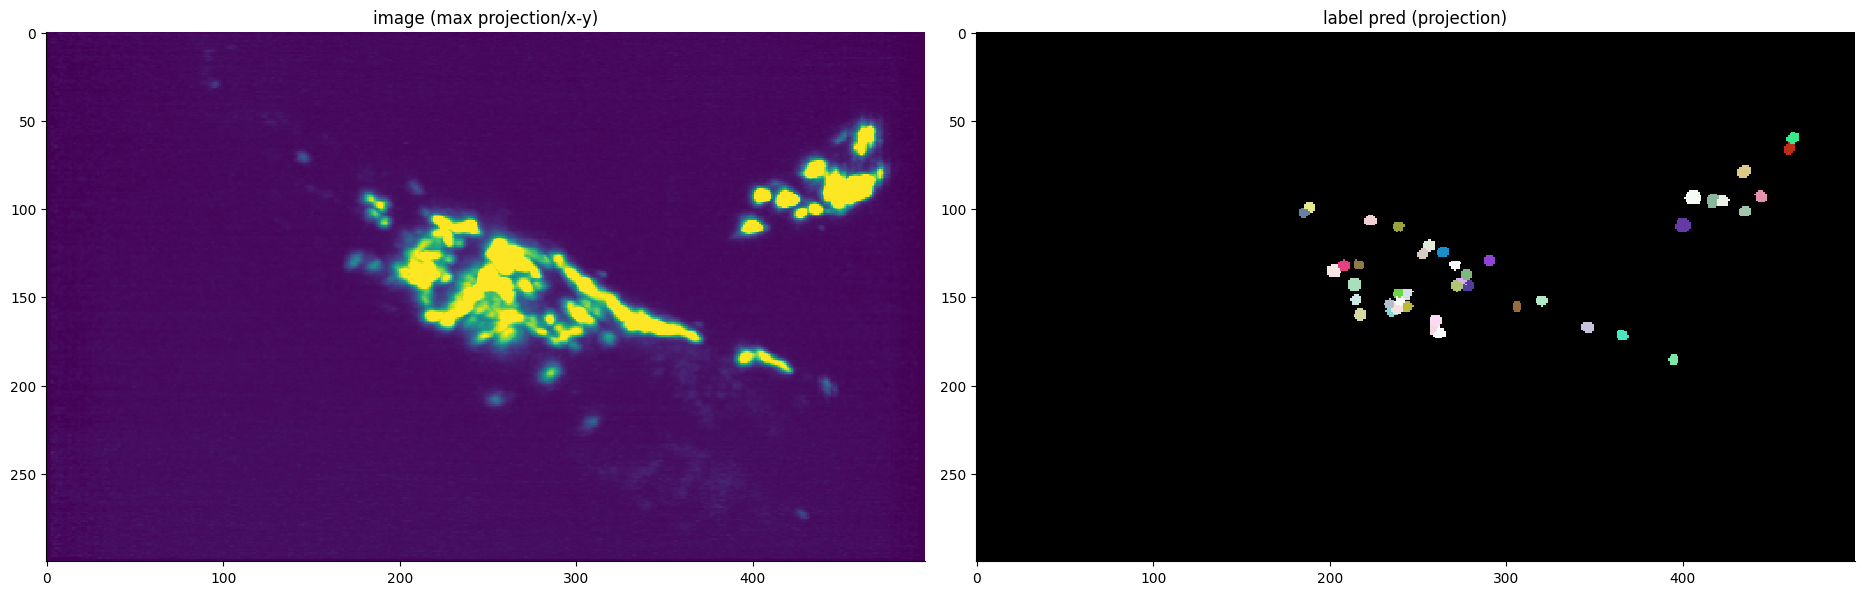

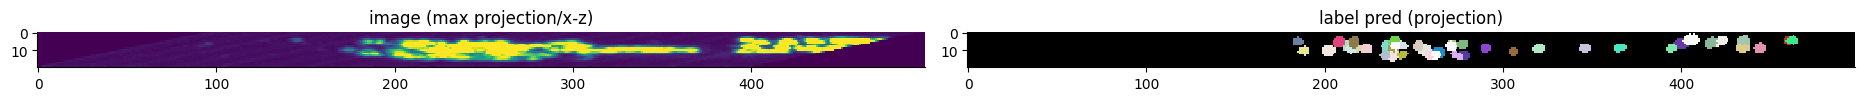

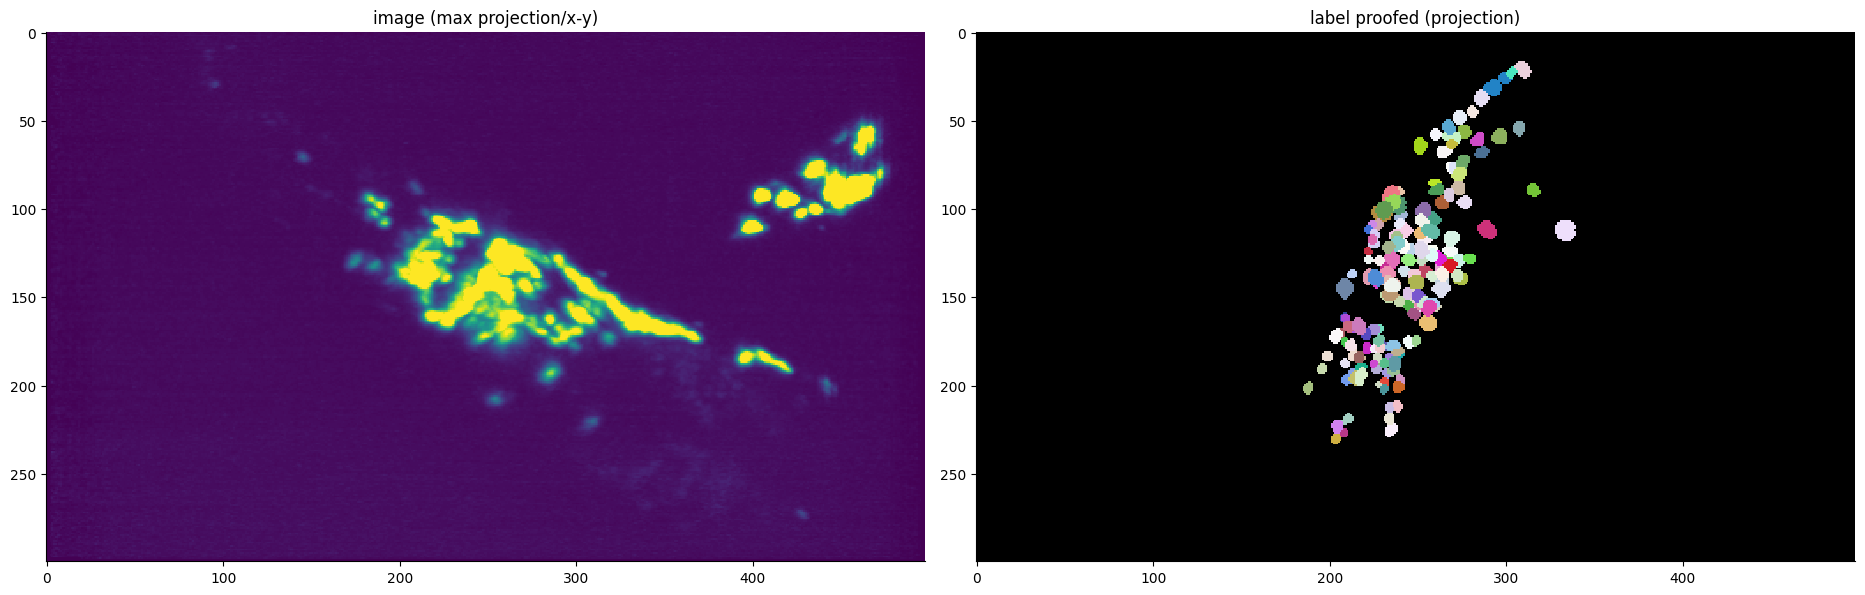

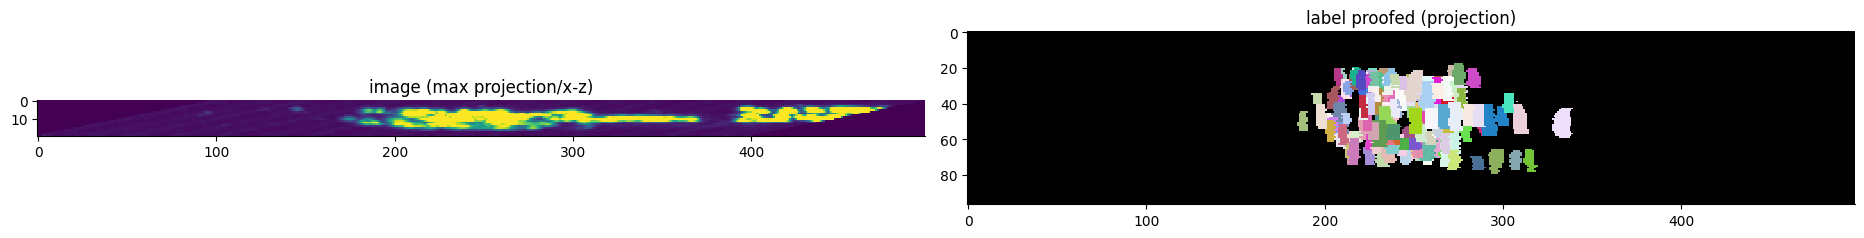

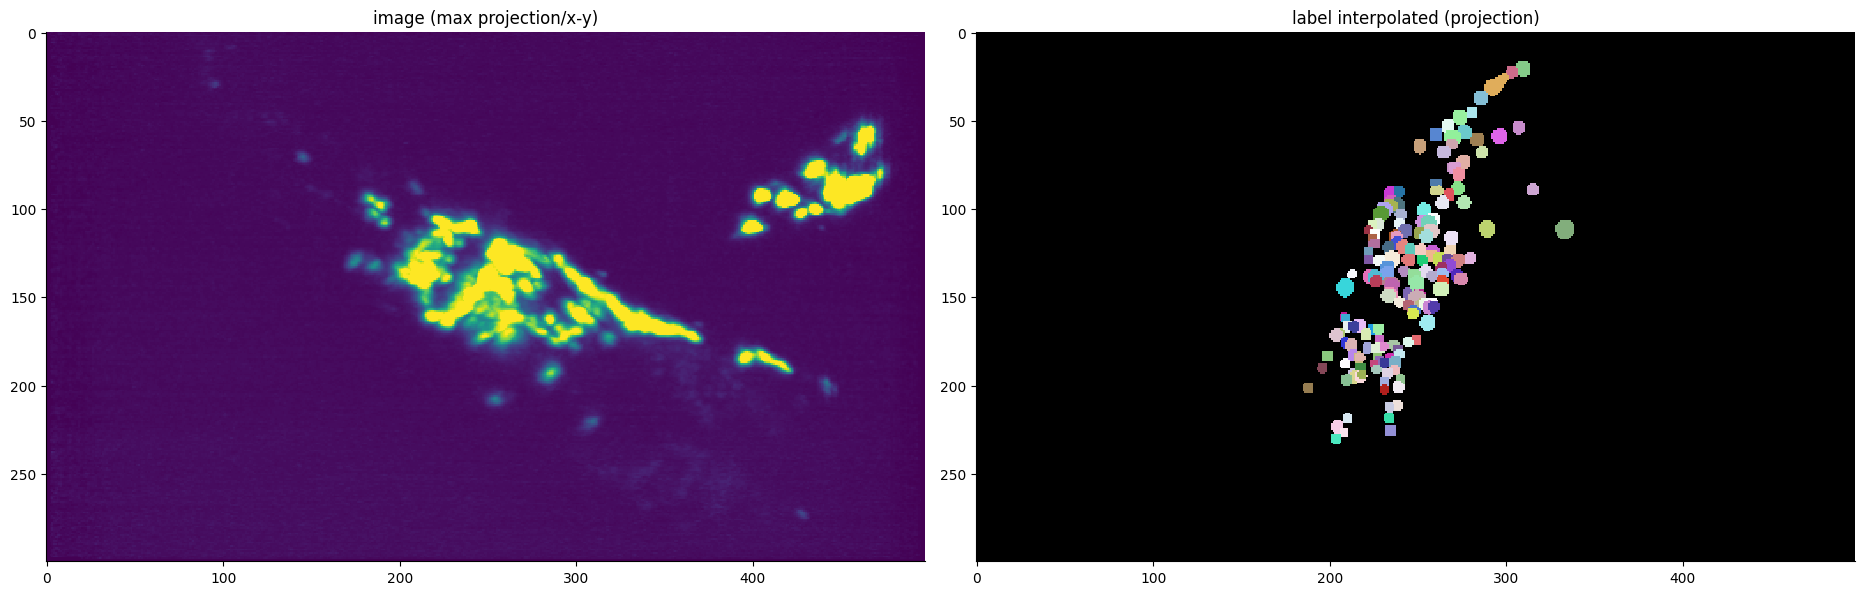

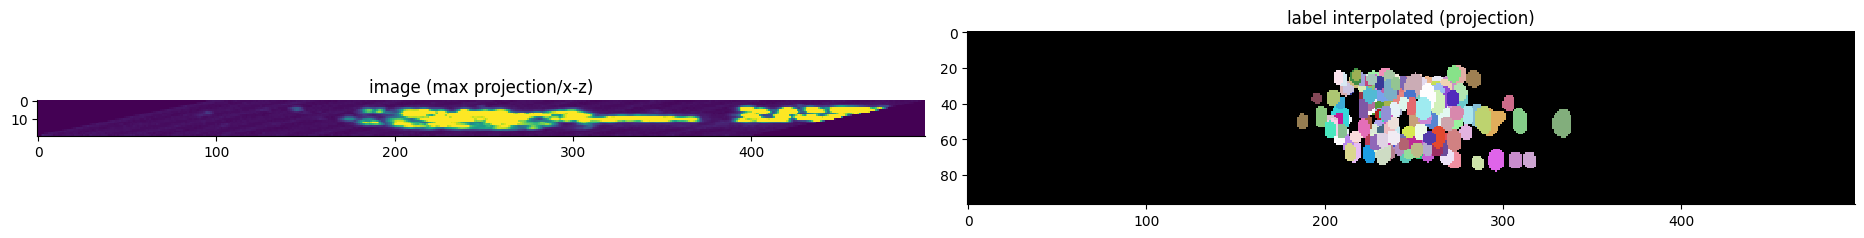

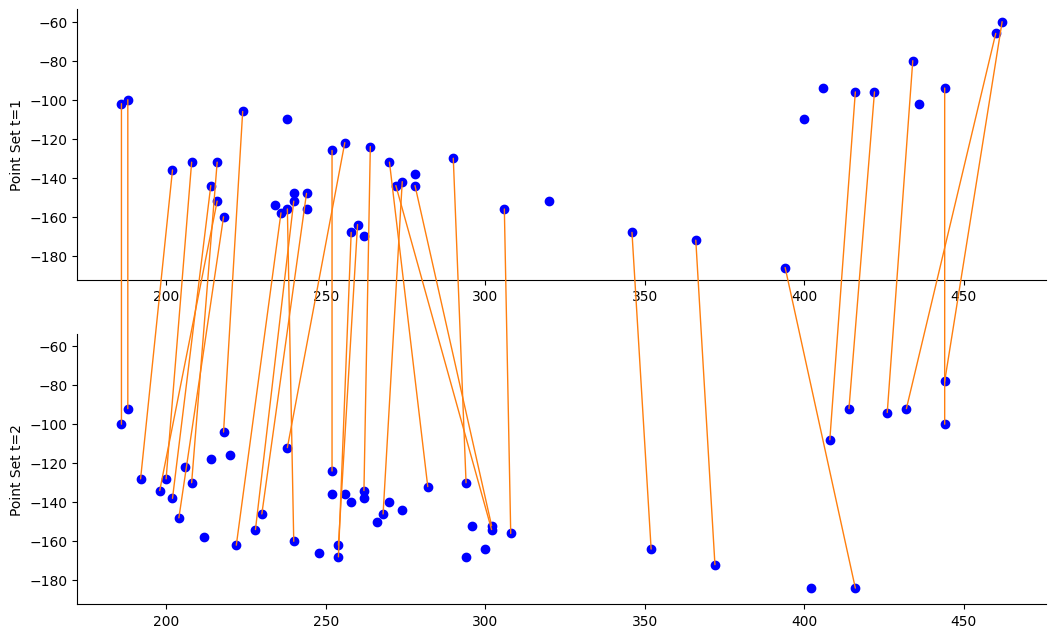

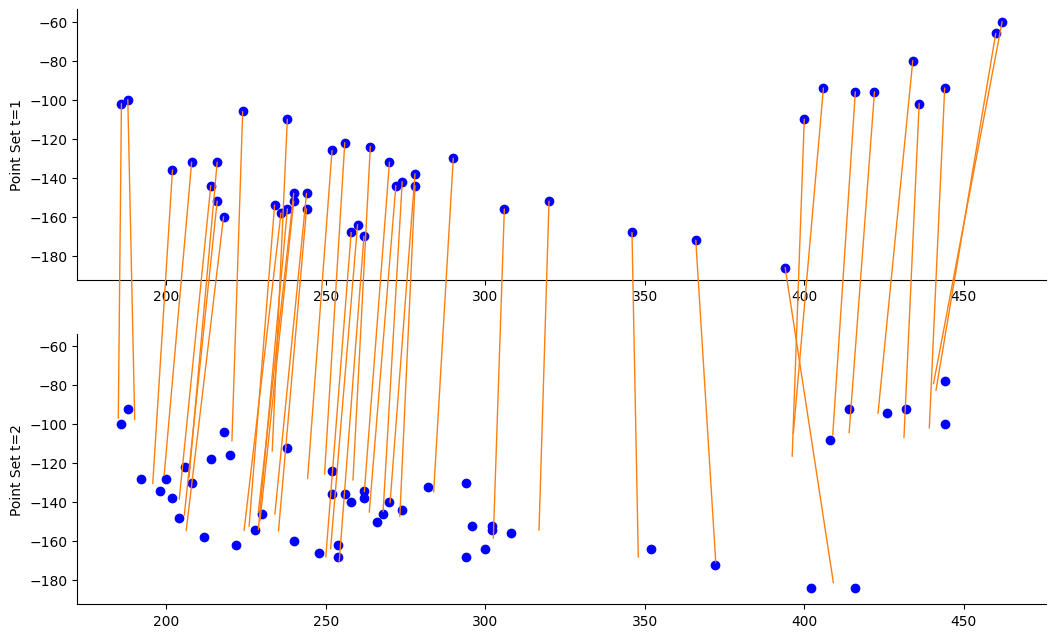

In [6]:
hdf5_folder_path = "D:/c.elegans/fluorescence_image/240218_Mikami_artifical/240217" #hdf5が入っているフォルダのpath

manual_vol1_path = "D:/c.elegans/3DeeCellTracker_result/20231101-175925tdTomato/raw/manual_vol1/image.tif"#マニュアルセグメンテーションデータが入っているファイル

t_start = 1
t_end = 2

ensemble = False

sampling_number = 10
##以上だけ指定

extension = "h5"

files = [h for h in os.listdir(hdf5_folder_path) if h.endswith(extension)]

for file_name in files:

    print("\n\n\n"+file_name+" is under processing\n\n\n")
        
    hdf5_file_path = os.path.join(hdf5_folder_path, file_name)

    path_results = os.path.join(hdf5_folder_path, file_name + "_track_result")

    path_raw_images = {"h5_file":hdf5_file_path,
                        "dset":"default",
                        "channel": 0}

    # Load raw image at vol 1
    vol = 1
    x = sdw.load_2d_slices_at_time(images_path=path_raw_images, t=vol)
    print(f"Raw image shape at vol1: {x.shape}")

    (labels, details), prob_map = model.predict_instances(x)
    use_8_bit = True if labels.max() <= 255 else False

    sdw.plot_img_label_max_projection(x, labels, lbl_title="label pred (projection)", fig_width_px=1800)


    scale_z = 1

    sdw.plot_img_label_max_projection_xz(x, labels, lbl_title="label pred (projection)", fig_width_px=1800, scale_z=scale_z)

    sdw.predict_and_save(images_path=path_raw_images, model=model, results_folder=path_results)


    voxel_size=(1, 1, 1)


    manual_seg_path=manual_vol1_path

    coords2image = cit.CoordsToImageTransformer(results_folder=path_results, voxel_size=voxel_size)
    coords2image.load_segmentation(manual_vol1_path=manual_seg_path)
    sdw.plot_img_label_max_projection(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800)
    sdw.plot_img_label_max_projection_xz(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800, scale_z=scale_z)


    interpolation_factor = 1

    coords2image.interpolate(interpolation_factor=interpolation_factor)
    sdw.plot_img_label_max_projection(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800)
    sdw.plot_img_label_max_projection_xz(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800,scale_z=scale_z)

    ffn_model_name="ffn_worm4"

    tracker = trl.TrackerLite(results_dir=path_results, ffn_model_name=ffn_model_name, proofed_coords_vol1=coords2image.coord_vol1)

    t1 = 1
    t2 = 2

    tracker.match_by_ffn(t1=t1, t2=t2)

    beta = 3
    lambda_= 3

    tracked_positions_t2 = tracker.predict_cell_positions(t1=t1, t2=t2, beta=lambda_, lambda_=beta, draw_fig=True)

    t_start = t_start
    t_end = t_end
    
    skipped_volumes = []

    t1 = t_start
    confirmed_coord = coords2image.coord_vol1
    grid = model.config.grid
    #for t in range(t_start+1, t_end+1):
        #print(f"t={t}...", end="\r")
        #if t in skipped_volumes:
            #print(f"skip t={t}")
            #continue
        #coord_prgls = tracker.predict_cell_positions(t1=t1, t2=t, confirmed_coord_t1=confirmed_coord, beta=beta, lambda_=lambda_, draw_fig=False)
        #confirmed_coord, corrected_labels_image = coords2image.accurate_correction(t, grid, coord_prgls, ensemble=ensemble)
        #coords2image.save_tracking_results(confirmed_coord, corrected_labels_image, tracker, t1=t1, t2=t, images_path=path_raw_images)
        #t1 = t

    for t in range(t_start+1, t_end+1):
        print(f"t={t}...", end="\r")
        if t in skipped_volumes:
            print(f"skip t={t}")
            continue
        coord_prgls = tracker.predict_cell_positions_ensemble(skipped_volumes=skipped_volumes, t2=t, coord_t1=confirmed_coord, beta=beta, lambda_=lambda_, 
                                                            sampling_number=sampling_number, adjacent=True)
        confirmed_coord, corrected_labels_image = coords2image.accurate_correction(t, grid, coord_prgls, ensemble)
        coords2image.save_tracking_results(confirmed_coord, corrected_labels_image, tracker, t1=t1, t2=t, images_path=path_raw_images)

